In [22]:
import torch
from torch import Tensor
import matplotlib.pyplot as plt
import numpy as np
import math

In [23]:
torch.set_grad_enabled( False )

3 Project 2 – Mini deep-learning framework

The objective of this project is to design a mini “deep learning framework” using only pytorch’s
tensor operations and the standard math library, hence in particular without using autograd or the
neural-network modules.

3.1 Objective

Your framework should import only torch.empty, and use no pre-existing neural-network python
toolbox. Your code should work with autograd globally off, which can be achieved with
torch . set˙grad˙enabled ( False )
Your framework must provide the necessary tools to:
     build networks combining fully connected layers, Tanh, and ReLU,
     run the forward and backward passes,
     optimize parameters with SGD for MSE.
You must implement a test executable named test.py that imports your framework and
 Generates a training and a test set of 1, 000 points sampled uniformly in [0, 1]2, each with a label 0 if outside the disk of radius 1/√2π and 1 inside,
 builds a network with two input units, two output units, three hidden layers of 25 units,2 of 3
 trains it with MSE, logging the loss,
 computes and prints the final train and the test errors.

3.2 Suggested structure
You are free to come with any new ideas you want, and grading will reward originality. The suggested simple structure is to define a class
class Module ( object ) :
    def forward ( self , * input ) :
        raise NotImplementedError
    def backward ( self , * gradwrtoutput ) :
        raise NotImplementedError
    def param ( self ) :
        return []
   and to implement several modules and losses that inherit from it.
Each such module may have tensor parameters, in which case it should also have for each a similarly sized tensor gradient to accumulate the gradient during the back-pass, and
 forward should get for input, and returns, a tensor or a tuple of tensors.
 backward should get as input a tensor or a tuple of tensors containing the gradient of the loss with respect to the module’s output, accumulate the gradient wrt the parameters, and return a tensor or a tuple of tensors containing the gradient of the loss wrt the module’s input.
 param should return a list of pairs, each composed of a parameter tensor, and a gradient tensor of same size. This list should be empty for parameterless modules (e.g. ReLU). Some modules may requires additional methods, and some modules may keep track of information from the forward pass to be used in the backward.
You should implement at least the modules Linear (fully connected layer), ReLU, Tanh, Sequential to combine several modules in basic sequential structure, and LossMSE to compute the MSE loss.

In [24]:
#Disclaimer: These two functions are strongly inspired of the DLC_practical file
def generate_disc_set(nb):
    input = Tensor(nb, 2).uniform_(-1, 1)
    target = 1-input.pow(2).sum(1).sub(2 / math.pi).sign().add(1).div(2).long() #1- because it was 1 outside and 0 inside
    return input, target

def convert_to_one_hot_labels(input, target):
    tmp = input.new_zeros(target.size(0), target.max() + 1)
    tmp.scatter_(1, target.view(-1, 1), 1.0)
    return tmp
train_input, train_target = generate_disc_set(1000);
test_input, test_target = generate_disc_set(1000);

mean, std = train_input.mean(), train_input.std();

train_input.sub_(mean).div_(std);
test_input.sub_(mean).div_(std);

#train_input, train_target = Variable(train_input), Variable(train_target)
#test_input, test_target = Variable(test_input), Variable(test_target)

Display dataset :

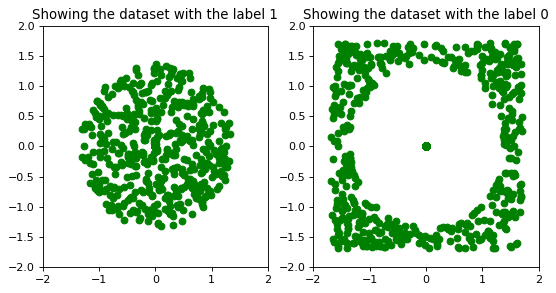

In [25]:
Label=train_target.view(-1).float() # 1- to display the other label
x1=(train_input.narrow(1,0,1).view(-1)*Label).numpy();
y1=(train_input.narrow(1,1,1).view(-1)*Label).numpy();
x0=(train_input.narrow(1,0,1).view(-1)*(1-Label)).numpy();
y0=(train_input.narrow(1,1,1).view(-1)*(1-Label)).numpy();
plt.figure(num=None, figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')

subplot=plt.subplot(1,2,1)
axes = plt.gca();
plt.title("Showing the dataset with the label 1");
subplot.plot(x1,y1,'go');
axes.set_xlim([-2,2]);
axes.set_ylim([-2,2]);
subplot=plt.subplot(1,2,2)
axes = plt.gca();
plt.title("Showing the dataset with the label 0");
subplot.plot(x0,y0,'go');
axes.set_xlim([-2,2]);
axes.set_ylim([-2,2]);

## Class definition

In [26]:
class Module ( object ) :
    def __init__(self):
        super(Module, self).__init__()
    def forward ( self , * input ) :
        for i in range(len(self.LinearList)):
            self.LinearList[i].forward()
    def backward ( self , * gradwrtoutput ) :
        raise NotImplementedError
    def param ( self ) :
        return []
    def sgd():
        batch = next_training_batch(data, self.batch_size)
        L = LossMSE(y_pred,y)    

In [27]:
class Sequential(Module):
    def __init__(self, param , loss):
        super(Module, self).__init__()
        self.model = (param)
        self.loss = loss
    def forward(self,x):
        for _object in self.model:
            x = _object.forward(x)
        return x
    
    def backward(self,y,y_pred,lr):
        grad_pred = self.loss.grad(y,y_pred)
        for _object in reversed(self.model):
            grad_pred = _object.backward(grad_pred,lr)
        
    
    def print(self):
        for _object in (self.model):
            _object.print()

In [28]:
class Linear(Module):
    def __init__(self, in_features, out_features):
        super(Module, self).__init__()
        self.x = 0
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.rand(size=(self.in_features,self.out_features))
        self.bias= torch.rand(self.out_features)
    def print(self):
            print([self.out_features,self.in_features])
    def print_weight(self):
        print(self.weight)

    
    def update(self, grad,lr):
        self.weight = self.weight - lr * self.x.t().mm(grad) 
        self.bias = self.bias - lr * grad * 1
    
    def backward(self,grad,lr):
        b = grad.mm(self.weight.t())
        self.update(grad,lr)
        return b
    
    def forward(self,x):
        self.x = x
        return x.mm(self.weight)+self.bias;

In [29]:
class ReLu(Module):
    
    def __init__(self ):
        super(Module, self).__init__()
        self.save=0;
    def forward(self,x):
        y = x.clamp(min = 0)
        self.save=x;
        return y
    def backward(self,x,lr):
        y=self.save>0
        return y.float()*x
         
    def print(self):
        print('relu')

In [30]:
class LossMSE(Module):
    def __init__(self, ):
        super(Module, self).__init__()
        
    def loss(self,y,y_pred):
        loss = (y_pred - y).pow(2).sum()
        return loss
    
    def grad(self,y,y_pred):
        return 2*(y_pred-y)

In [34]:
class Tanh(Module):
    def __init__(self, ):
        object.__init__(self)
        
    def forward(self,x):
        y = (x.exp() - (-x).exp()) / ( x.exp() +  (-x).exp())
        return y
    def backward(self,x,lr):
        return 4 * (x.exp() + (-x).exp()).pow(-2)
    def print(self):
        print('tanh')

In [32]:
def compute_nb_errors(model, data_input, data_target):
    nb_data_errors = 0

    for b in range(0, data_input.size(0), mini_batch_size):
        output = model.forward(data_input.narrow(0, b, mini_batch_size))
        _, predicted_classes = torch.max(output.data, 1)
        for k in range(mini_batch_size):
            if data_target.data[b + k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1

    return nb_data_errors

In [36]:
X=Tensor([[1,0,4],[1,0,4]])
YX=Tensor([[1,0,4,2,4],[1,0,4,2,4],[1,0,4,2,4]])


In [37]:
s = Sequential([Linear(3,5),ReLu()], LossMSE())
x = Tensor([[1,2,3]])
y = Tensor([0.5,1,1.5,1,4])
lr=0.1
y_pred = s.forward(x)
s.model[0].print_weight()
s.backward(y,y_pred,lr)
s.model[0].print_weight()


tensor([[0.4140, 0.5716, 0.8341, 0.3379, 0.7022],
        [0.3450, 0.3502, 0.4613, 0.9537, 0.8839],
        [0.6730, 0.2155, 0.4212, 0.5486, 0.4237]])
tensor([[-0.1416,  0.3734,  0.4810, -0.2548,  0.7149],
        [-0.7661, -0.0460, -0.2449, -0.2316,  0.9093],
        [-0.9936, -0.3789, -0.6380, -1.2294,  0.4618]])


In [ ]:
Module()
linear(5,5)
linear.Relu

linear(5,3)

In [40]:
# train_input, train_target
nb_epochs=50
mini_batch_size=1
Model = Sequential([Linear(2,128),ReLu(),Linear(128,2),ReLu()], LossMSE())
print("Before_Training Nb_Error: ",compute_nb_errors(Model,train_input, train_target))
train_target_one_hot= convert_to_one_hot_labels(train_input,train_target)
for epochs in range(0,nb_epochs):
    for b in range(0, train_input.size(0), 1):
        output = Model.forward(train_input.narrow(0, b, 1))
        Model.backward(train_target_one_hot.narrow(0, b, 1),output,0.0009)
    print("Epoch:",epochs+1, "Train Error: ",compute_nb_errors(Model,train_input, train_target)/train_input.size(0)*100,"%","Test Error:",compute_nb_errors(Model,test_input, test_target)/test_input.size(0)*100,"%")
    

Before_Training Nb_Error:  559
Epoch: 1 Train Error:  35.3 % Test Error: 36.199999999999996 %
Epoch: 2 Train Error:  34.5 % Test Error: 36.0 %
Epoch: 3 Train Error:  34.5 % Test Error: 35.9 %
Epoch: 4 Train Error:  33.5 % Test Error: 34.699999999999996 %
Epoch: 5 Train Error:  30.9 % Test Error: 32.2 %
Epoch: 6 Train Error:  27.400000000000002 % Test Error: 29.5 %
Epoch: 7 Train Error:  17.1 % Test Error: 18.7 %
Epoch: 8 Train Error:  16.2 % Test Error: 16.900000000000002 %
Epoch: 9 Train Error:  15.4 % Test Error: 16.1 %
Epoch: 10 Train Error:  14.6 % Test Error: 16.1 %
Epoch: 11 Train Error:  13.4 % Test Error: 14.499999999999998 %
Epoch: 12 Train Error:  12.8 % Test Error: 11.5 %
Epoch: 13 Train Error:  16.3 % Test Error: 16.8 %
Epoch: 14 Train Error:  15.7 % Test Error: 16.1 %
Epoch: 15 Train Error:  16.0 % Test Error: 16.3 %
Epoch: 16 Train Error:  15.7 % Test Error: 16.8 %
Epoch: 17 Train Error:  15.6 % Test Error: 16.7 %
Epoch: 18 Train Error:  14.299999999999999 % Test Error: 1

In [39]:
# train_input, train_target
nb_epochs=50
mini_batch_size=1
Model = Sequential([Linear(2,128),Tanh(),Linear(128,2),Tanh()], LossMSE())
print("Before Training: Train Error: ",compute_nb_errors(Model,train_input, train_target)/train_input.size(0)*100,"%","Test Error:",compute_nb_errors(Model,test_input, test_target)/test_input.size(0)*100,"%")
train_target_one_hot= convert_to_one_hot_labels(train_input,train_target)
for epochs in range(0,nb_epochs):
    for b in range(0, train_input.size(0), 1):
        output = Model.forward(train_input.narrow(0, b, 1))
        Model.backward(train_target_one_hot.narrow(0, b, 1),output,0.0008)
    print("Epoch:",epochs+1, "Train Error: ",compute_nb_errors(Model,train_input, train_target)/train_input.size(0)*100,"%","Test Error:",compute_nb_errors(Model,test_input, test_target)/test_input.size(0)*100,"%")
    

Before Training: Train Error:  54.0 % Test Error: 52.5 %
Epoch: 1 Train Error:  55.2 % Test Error: 51.5 %
Epoch: 2 Train Error:  53.1 % Test Error: 51.9 %
Epoch: 3 Train Error:  49.8 % Test Error: 48.8 %
Epoch: 4 Train Error:  52.2 % Test Error: 50.2 %
Epoch: 5 Train Error:  52.2 % Test Error: 50.2 %
Epoch: 6 Train Error:  52.2 % Test Error: 50.2 %
Epoch: 7 Train Error:  52.2 % Test Error: 50.2 %
Epoch: 8 Train Error:  52.2 % Test Error: 50.2 %
Epoch: 9 Train Error:  52.2 % Test Error: 50.2 %
Epoch: 10 Train Error:  52.2 % Test Error: 50.2 %
Epoch: 11 Train Error:  52.2 % Test Error: 50.2 %
Epoch: 12 Train Error:  47.8 % Test Error: 49.8 %
Epoch: 13 Train Error:  47.8 % Test Error: 49.8 %
Epoch: 14 Train Error:  47.8 % Test Error: 49.8 %


KeyboardInterrupt: 